In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
import torch

pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])

!pip install iopath
!pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

print(f"pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html
pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html


In [47]:
# Full imports
import torch
from blockgen.configs import VoxelConfig, DiffusionConfig
from blockgen.utils import create_model_and_trainer, create_dataloaders
from blockgen.inference import DiffusionInference3D
from scripts.generate import load_model_for_inference
from blockgen.utils.metrics import compute_metrics
from blockgen.utils.evaluate import evaluate_generation

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [25]:
# Configs
shape_voxel_config = VoxelConfig(
        mode='two_stage',
        stage='shape',
        default_color=[0.5, 0.5, 0.5],
        alpha_weight=1.0,
        rgb_weight=1.0
    )

color_voxel_config = VoxelConfig(
        mode='two_stage',
        stage='color',
        default_color=[0.5, 0.5, 0.5],
        alpha_weight=1.0,
        rgb_weight=1.0
    )

shape_diffusion_config = DiffusionConfig(
        num_timesteps=1000,
        use_ema=True,  # Enable EMA
        ema_decay=0.9999,
        ema_update_after_step=0,
        ema_device=device,
        use_ddim=False, 
        seed=42  # Set seed for reproducibility
    )

color_diffusion_config = DiffusionConfig(
        num_timesteps=1000,
        use_ema=True,  # Enable EMA
        ema_decay=0.9999,
        ema_update_after_step=0,
        ema_device=device,
        use_ddim=False, 
        seed=42  # Set seed for reproducibility
    )

## Training

In [ ]:
# Create model and trainer
trainer, model = create_model_and_trainer(
    voxel_config=voxel_config,
    diffusion_config=diffusion_config,
    resolution=32,
    device=device
)

In [ ]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=diffusion_config,
    config_voxel=voxel_config,
    batch_size=3
)

In [ ]:
metrics = trainer.train(
    train_loader,
    test_loader,
    total_steps=60_000,
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/experiment_color_60k',
    checkpoint_path='/scratch/students/2024-fall-sp-pabdel/3D-BlockGen/runs/experiment_color_60k/checkpoints/checkpoint_step_50000.pth'
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_losses'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['test_steps'], metrics['test_losses'])
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

## Inference

In [30]:
shape_model = load_model_for_inference(
        model_path="runs/finetune/shape/models/model_step_135000",
        voxel_config=shape_voxel_config,
        diffusion_config=shape_diffusion_config,
        device='cuda',
        ema=True
    )

color_model = load_model_for_inference(
        model_path="runs/experiment_two_stage/color/models/model_step_110000",
        voxel_config=color_voxel_config,
        diffusion_config=color_diffusion_config,
        device='cuda',
        ema=True
    )

The number of input channels is: 1 The number of out channels is1


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 11000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Total parameters: 120096449
Loaded EMA model weights
The number of input channels is: 4 The number of out channels is3


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 110000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Total parameters: 120099331
Loaded EMA model weights


In [31]:
# Inference
inferencer = DiffusionInference3D(
        model=shape_model,
        noise_scheduler=shape_model.noise_scheduler,
        color_model=color_model,
        color_noise_scheduler=color_model.noise_scheduler,
        device='cuda'
    )

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

### Combined/Shape only model

In [18]:
samples = inferencer.sample(
    prompt="fish",
    num_samples=1,
    image_size=(32, 32, 32),
    show_intermediate=False,
    guidance_scale=2,
    use_mean_init=False,
    py3d=False,
    use_rotations=False
)


ampling Steps: 100%|███████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]

In [ ]:
inferencer.visualize_samples(samples, threshold=0.5)

### Two stage

Stage 1: Generating shapes...



ampling Steps: 100%|███████████████████████| 1000/1000 [02:32<00:00,  6.57it/s]


Shape stage completed. Visualization:

Shape occupancy: 413 voxels (1.26%)


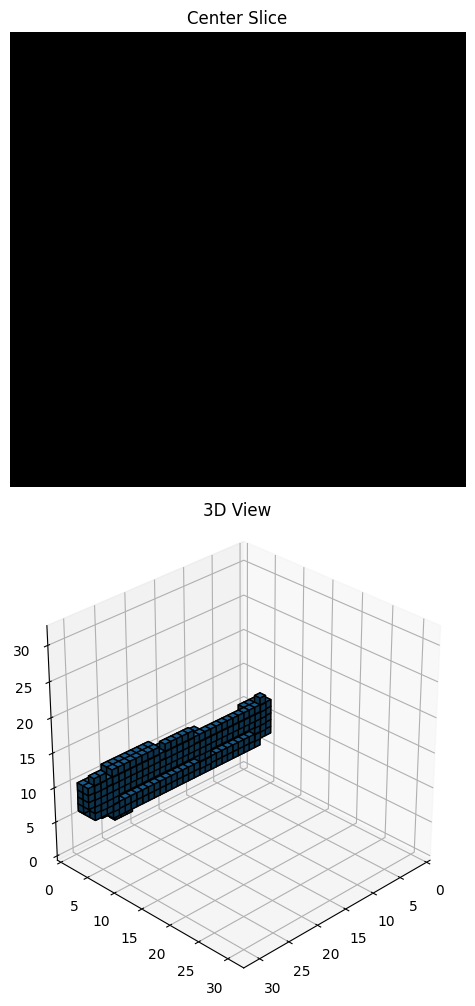


Stage 2: Adding colors...



olor Sampling: 100%|███████████████████████| 1000/1000 [02:30<00:00,  6.64it/s]

In [33]:
samples = inferencer.sample_two_stage(
        prompt="sawyer fish, blue, yellow fins, striped",
        num_samples=1,
        image_size=(32, 32, 32),
        guidance_scale=12.0,
        color_guidance_scale=10.0,
        show_after_shape=True,
        use_rotations=False, 
        use_mean_init=False
    )

In [37]:
target = torch.load("evaluation_set_voxelized/sawyer_fish_001.pt")


Sample Statistics:
Occupancy:
- Total voxels: 32768
- Occupied voxels: 413 (1.26%)

Color Statistics (occupied voxels):

Red Channel:
- Range: [0.000, 0.618]
- Mean: 0.307
- Std: 0.124

Green Channel:
- Range: [0.000, 0.599]
- Mean: 0.336
- Std: 0.101

Blue Channel:
- Range: [0.188, 0.951]
- Mean: 0.505
- Std: 0.125

Overall RGB Statistics:
- Mean intensity: 0.382
- Color variance: 0.146

Color Distribution:
- Dominant Red: 6.1%
- Dominant Green: 3.4%
- Dominant Blue: 47.2%


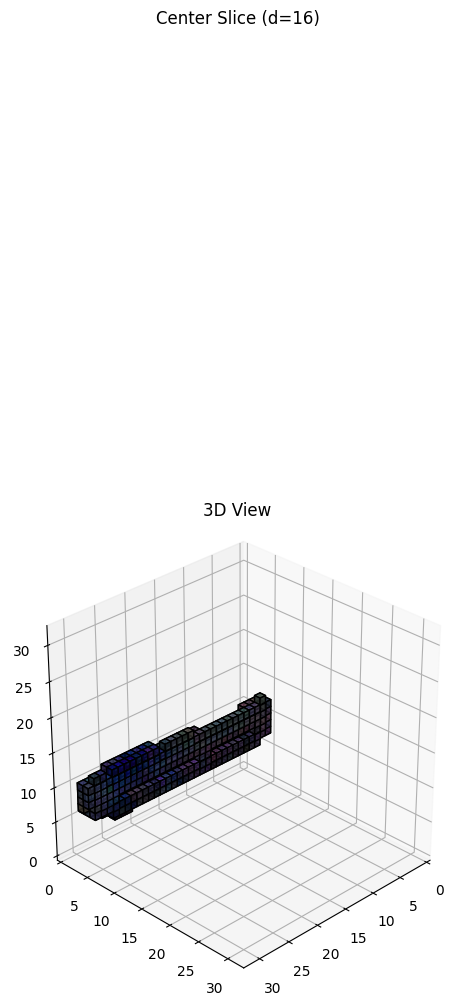

In [41]:
inferencer.visualize_samples(samples, threshold=0.5)

In [ ]:
inferencer.visualize_samples_p3d(samples[0], threshold=0.5)

## Evaluation

In [ ]:
# Path to your test data and annotations
test_data_dir = "evaluation_set_voxelized"
annotation_file = "evaluation_set/annotations.json"  

# Run evaluation with different parameters
metrics = evaluate_generation(
    shape_model=shape_model,
    color_model=color_model,
    test_data_dir=test_data_dir,
    annotation_file=annotation_file,
    num_eval_samples=8, # actual number of elements in the dataset
    guidance_scale=15.0,  
    color_guidance_scale=15.0,  
    use_rotations=False,
    device='cuda'
)

# Print results in a formatted way
print("\nEvaluation Results:")
print("-" * 50)
for metric_name, value in metrics.items():
    print(f"{metric_name:15s}: {value:.4f}")

Evaluating 8 samples


Generating samples:   0%|                                 | 0/8 [00:00<?, ?it/s]


Current prompt: apple fruit, food red, round, shiny, fresh
Stage 1: Generating shapes...



Stage 2: Adding colors...















































































































































































































































or Sampling:  24%|█████▋                  | 236/1000 [00:35<01:55,  6.62it/s]

RGB range: [0.000, 0.949]
Alpha range: [0.000, 1.000]
Occupied voxels: 1380 (4.21% of volume)


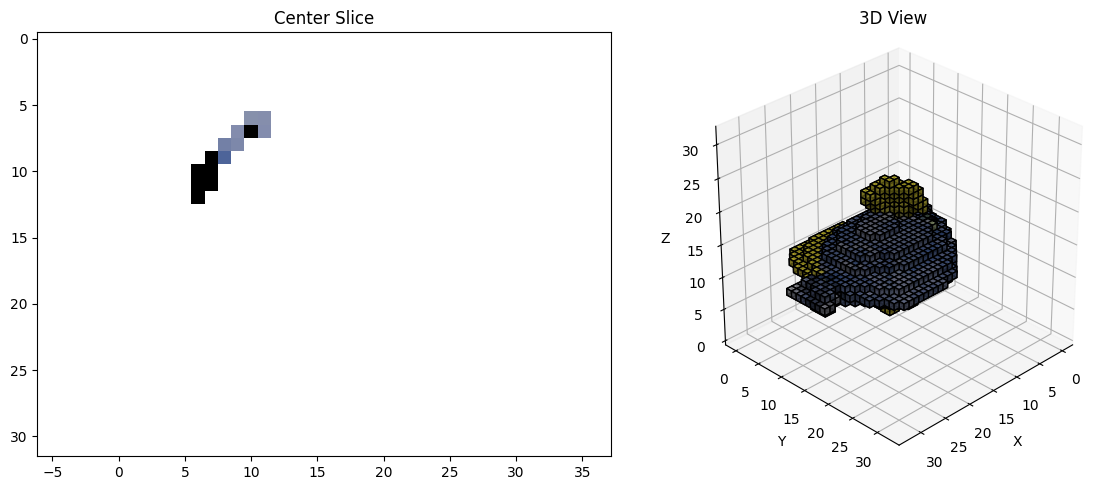

In [28]:
from blockgen.utils import plot_voxel_tensor
import matplotlib.pyplot as plt

plot_voxel_tensor(torch.load("evaluation_set_voxelized/sawyer_fish_001.pt"))

plt.show()

In [ ]:
from datasets import load_dataset

dataset = load_dataset("PeterAM4/blockgen-3d")
print("Train size:", len(dataset['train']))
print("Test size:", len(dataset['test']))